approx 200 arcmins

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
import torch
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import sqrt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
loop=1
nant=32
max_baseline=4.0

for _ in range(loop):  # Use _ since loop variable is not used inside
    ant_array = []
    for i in range(nant):
        xx = torch.rand(1).item() * max_baseline
        yy = torch.rand(1).item() * max_baseline
        ant_array.append([xx, yy])

    ant_pos = torch.tensor(ant_array)
    params = ant_pos.flatten()


In [3]:
def baselines_and_indicies_ect(param):

    ant_pos=param.reshape(nant,2)

    width=256
    center_position=[128,128]
    max_baseline=4.0

    # Calculate baselines
    baseline_array = []
    for i in range(nant):
        for j in range(nant):
            if i != j:
                a1 = ant_pos[i]
                a2 = ant_pos[j]
                u = a1[0] - a2[0]
                v = a1[1] - a2[1]
                baseline_array.append([u, v])

    baselines = torch.tensor(baseline_array)


    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False)

    for u, v in baselines:
        u_index = int((u + max_baseline) * width / (2 * max_baseline))
        v_index = int((v + max_baseline) * width / (2 * max_baseline))
        if 0 <= u_index < width and 0 <= v_index < width:
            uv[u_index, v_index] = 1


    uv = uv.clone()
    new_uv = uv.clone()  
    new_uv[u_index, v_index] = 1

    sky = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False)
    sky = sky.clone()  
    sky[width // 2, width // 2] = 1

    sky_im=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

    mask = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= (1)**2

    masked_im = sky_im * mask
    outofmask=sky_im-masked_im
    


    return sky_im, sky, new_uv, baselines, masked_im, outofmask

In [4]:
def loss_func(masked_im,outofmask, module=torch):
    
    loss = (module.abs(masked_im).sum())**2/(module.abs((outofmask)).sum() + module.abs(masked_im).sum() )**2
    #+ module.abs(masked_uv).sum()
    return loss

In [5]:
loop = 25000
ratio = []
nant=32
max_baseline=4

worst_ratio = float('inf')  # Initialize with a very low value
worst_params = None

best_ratio = float('-inf')  # Initialize with a very low value
best_params = None


for _ in range(loop):  # Use _ since loop variable is not used inside
    ant_array = []
    for i in range(nant):
        xx = torch.rand(1).item() * max_baseline
        yy = torch.rand(1).item() * max_baseline
        ant_array.append([xx, yy])

    ant_pos = torch.tensor(ant_array)
    params = ant_pos.flatten()

    sky_im, sky, new_uv, baselines, masked_im, outofmask = baselines_and_indicies_ect(params)
    
    nt_ratio = loss_func(masked_im, outofmask, module=np)
    ratio.append(nt_ratio)

    if nt_ratio < worst_ratio:
        worst_ratio = nt_ratio
        worst_params = params

    if nt_ratio > best_ratio:
        best_ratio = nt_ratio
        best_params = params
# Now, best_ratio holds the highest ratio and best_params holds the corresponding parameters

ratio;


/Users/georgebrown/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


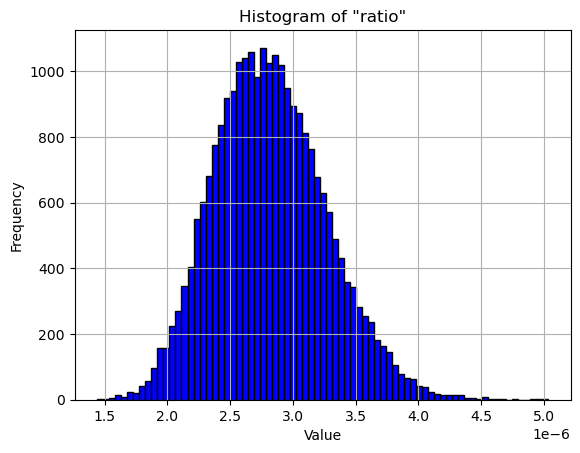

In [6]:
plt.hist(ratio, bins=75, color='blue', edgecolor='black')
plt.title('Histogram of "ratio"')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("ratio_test_100,000its_75_bins.png")
plt.show()

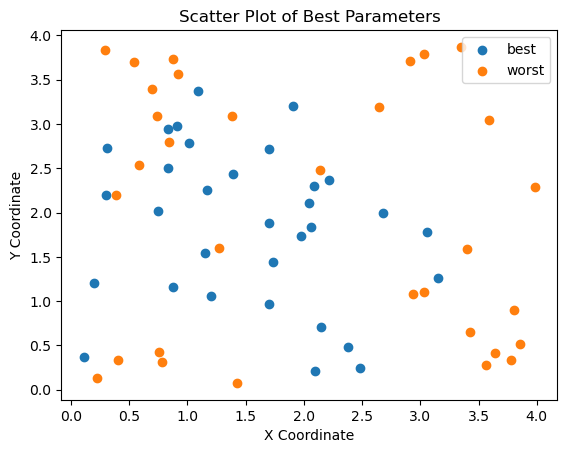

In [7]:
# Assuming best_params is a 1D tensor with shape (2 * nant,)
nant = len(best_params) // 2
a = best_params.reshape(nant, 2)
b = worst_params.reshape(nant, 2)

# Extract x and y coordinates
x_coords = a[:, 0].numpy()
y_coords = a[:, 1].numpy()

x_coords_b = b[:, 0].numpy()
y_coords_b = b[:, 1].numpy()

# Create the scatter plot
plt.scatter(x_coords, y_coords, label='best')
plt.scatter(x_coords_b, y_coords_b,label='worst')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Best Parameters')
plt.legend()
plt.savefig('antenna coords')
plt.show()

In [8]:
def imageing_from_pos(param):

    ant_pos=param.reshape(nant,2)

    width=256
    center_position=[128,128]
    max_baseline=4.0

    # Calculate baselines
    baseline_array = []
    for i in range(nant):
        for j in range(nant):
            if i != j:
                a1 = ant_pos[i]
                a2 = ant_pos[j]
                u = a1[0] - a2[0]
                v = a1[1] - a2[1]
                baseline_array.append([u, v])

    baselines = torch.tensor(baseline_array)


    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False)

    for u, v in baselines:
        u_index = int((u + max_baseline) * width / (2 * max_baseline))
        v_index = int((v + max_baseline) * width / (2 * max_baseline))
        if 0 <= u_index < width and 0 <= v_index < width:
            uv[u_index, v_index] = 1


    uv = uv.clone()
    new_uv = uv.clone()  
    new_uv[u_index, v_index] = 1

    sky = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False)
    sky = sky.clone()  
    sky[width // 2, width // 2] = 1

    sky_im=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

    mask = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= 1**2

    masked_im = sky_im * mask
    outofmask=sky_im-masked_im
    

    return sky_im, sky, new_uv, baselines, masked_im, outofmask

In [9]:
sky_im_best, sky_best, new_uv_best, baselines_best, masked_uv_best, outofmask_best = imageing_from_pos(best_params)

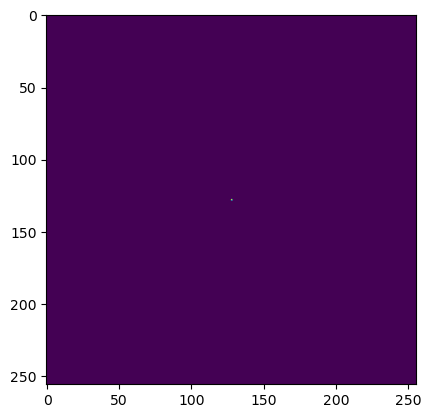

In [10]:
making_sky_im=(np.abs(sky.detach().numpy()))
plt.imshow(making_sky_im)
plt.savefig('sky')
plt.show()

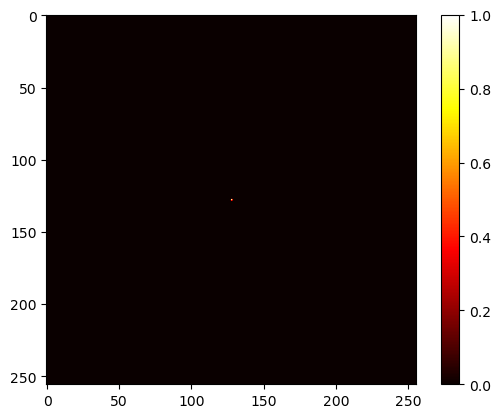

In [11]:
making_sky_im=(np.abs(sky.detach().numpy()))
plt.imshow(making_sky_im,cmap='hot')
plt.colorbar()
#plt.savefig('bad image?')
plt.show()

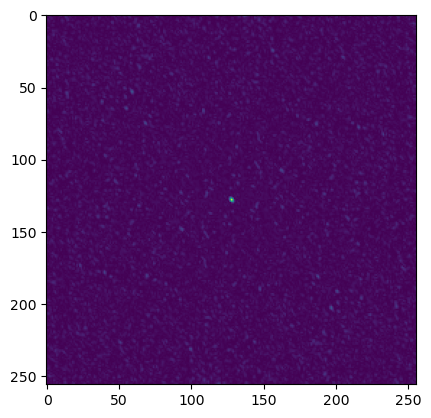

In [12]:
making_sky_im=(np.abs(sky_im_best.detach().numpy()))
plt.imshow(making_sky_im)
plt.savefig('bad image?')
plt.show()

In [13]:
sky_im_best_n=sky_im_best.detach().numpy()
np.abs(np.max(sky_im_best_n))

0.014831543

In [14]:
np.abs(np.min(sky_im_best_n))


0.0020083026

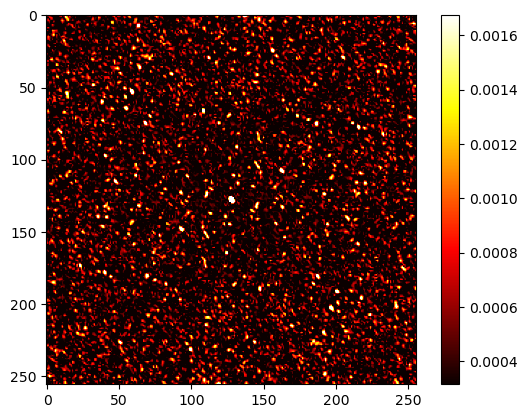

In [15]:
making_sky_im=(np.abs(sky_im_best.detach().numpy()))

vmin = 0.0016765051
vmax = 0.00035


plt.imshow(making_sky_im,cmap='hot',vmin=vmin, vmax=vmax)
plt.colorbar()
#plt.savefig('bad image?')
plt.show()

In [16]:
sky_im_worst, sky_worst, new_uv_worst, baselines_worst, masked_uv_worst, outofmask_worst = imageing_from_pos(worst_params)

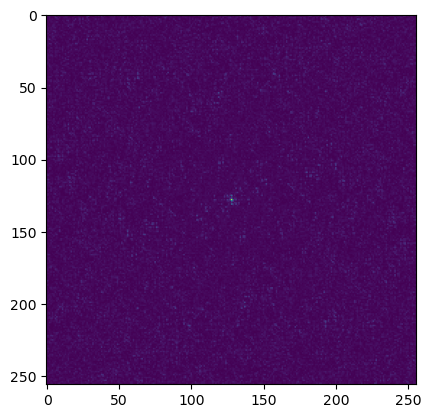

In [17]:
making_sky_im=(np.abs(sky_im_worst.detach().numpy()))
plt.imshow(making_sky_im)
plt.savefig('good image?')
plt.show()

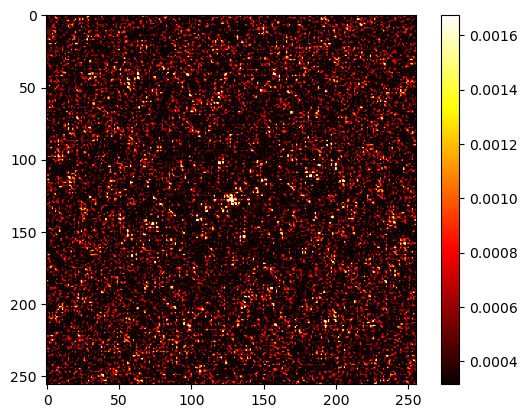

In [18]:
making_sky_im=(np.abs(sky_im_worst.detach().numpy()))
vmin = 0.0016765051
vmax = 0.00035
plt.imshow(making_sky_im,cmap='hot',vmin=vmin, vmax=vmax)
plt.colorbar()
#plt.savefig('bad image?')
plt.show()